<a href="https://colab.research.google.com/github/sonv1x/sales-forecast/blob/main/sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data shape: (365, 3)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.05          7979.46       11          15.1161           9.8085     14.69s
   1     6.95          401.256       13          14.0944          18.7258     14.53s
   2     6.58          796.451       12           14.143          18.3015     12.78s
   3    10.66          1162.77       18          12.4977          13.5855     13.52s
   4    11.87          1417.67       16          12.1007          17.0467     16.71s
   5    13.18          1965.96       18          11.8495          19.3358     19.07s
   6    18.81          7213.58       18          11.9259          18.5922     14.50s
   7    21.11          5188.11       24          11.9173          18.6451     11.79s
   8    19.39          8545.87       30          12.0265          17.8788  

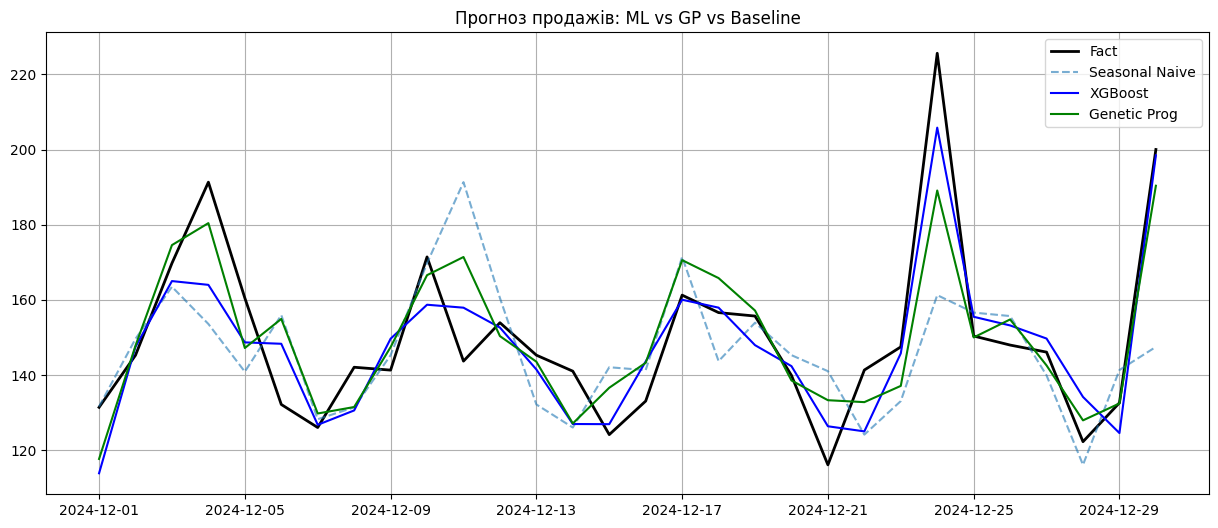


Моделі збережено у .pkl файли


In [10]:
# 1. Встановлення бібліотеки (якщо ще не встановлена)
try:
    import gplearn
except ImportError:
    !pip install gplearn
    print("gplearn встановлено!")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from gplearn.genetic import SymbolicRegressor

# Фіксація Random Seed для відтворюваності
SEED = 42
np.random.seed(SEED)

# КРОК 1: ГЕНЕРАЦІЯ ДАНИХ (Синтетика)
def generate_data(n_days=365):
    dates = pd.date_range(start='2024-01-01', periods=n_days, freq='D')

    # Тренд (лінійне зростання)
    trend = np.linspace(100, 150, n_days)

    # Сезонність (тижнева - синус)
    seasonality = 20 * np.sin(2 * np.pi * np.arange(n_days) / 7)

    # Промо-акції (випадкові сплески)
    promo = np.random.choice([0, 1], size=n_days, p=[0.9, 0.1])
    promo_effect = promo * 50  # Промо додає 50 продажів

    # Випадковий шум
    noise = np.random.normal(0, 10, n_days)

    # Підсумкові продажі (не можуть бути від'ємними)
    sales = trend + seasonality + promo_effect + noise
    sales = np.maximum(sales, 0)

    df = pd.DataFrame({
        'date': dates,
        'sales': sales,
        'promo': promo
    })
    return df

# Генеруємо дані за рік
df = generate_data(n_days=365)
print(f"Data shape: {df.shape}")

# КРОК 2: FEATURE ENGINEERING
def create_features(df):
    df = df.copy()
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Лаги (минулі значення)
    # Важливо: якщо горизонт прогнозу 1 день, беремо lag_1.
    # Якщо будуємо модель на тиждень вперед, найменший лаг має бути 7.
    df['lag_1'] = df['sales'].shift(1)
    df['lag_7'] = df['sales'].shift(7)
    df['lag_14'] = df['sales'].shift(14)

    # Ковзні середні (Rolling features)
    df['rolling_mean_7'] = df['sales'].shift(1).rolling(window=7).mean()
    df['rolling_std_7'] = df['sales'].shift(1).rolling(window=7).std()

    # Видаляємо NaN, що з'явилися через лаги
    df = df.dropna()
    return df

df_features = create_features(df)

# Розбиття на Train/Test (часовий порядок)
# Останні 30 днів - тест
test_days = 30
train_df = df_features.iloc[:-test_days]
test_df = df_features.iloc[-test_days:]

features = ['promo', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7']
target = 'sales'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# КРОК 3: БАЗОВІ ЛІНІЇ (Baselines)
# Naive: Прогноз = вчорашнє значення
pred_naive = X_test['lag_1']

# Seasonal Naive: Прогноз = значення тиждень тому
pred_snaive = X_test['lag_7']

# КРОК 4: ML ПІДХІД (XGBoost)
model_xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=SEED,
    objective='reg:squarederror'
)

# Валідація TimeSeriesSplit (для прикладу, але тренуємо на повному трейні)
tscv = TimeSeriesSplit(n_splits=3)
for train_index, val_index in tscv.split(X_train):
    X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]
    model_xgb.fit(X_t, y_t)
    # Тут можна збирати метрики валідації

# Фінальне навчання
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)

# Важливість ознак
importances = pd.Series(model_xgb.feature_importances_, index=features).sort_values(ascending=False)

# КРОК 5: ГЕНЕТИЧНЕ ПРОГРАМУВАННЯ (Symbolic Regression)
# gplearn шукає математичну формулу, що описує залежність
est_gp = SymbolicRegressor(
    population_size=1000,
    generations=20,
    tournament_size=20,
    stopping_criteria=0.01,
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    parsimony_coefficient=0.01, # Штраф за складність формули
    random_state=SEED,
    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv']
)

est_gp.fit(X_train, y_train)
pred_gp = est_gp.predict(X_test)

print(f"\nЗнайдена формула GP: {est_gp._program}")

# КРОК 6: ОЦІНКА ТА ПОРІВНЯННЯ
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape}

results = []
results.append(evaluate(y_test, pred_naive, 'Naive (Last Value)'))
results.append(evaluate(y_test, pred_snaive, 'Seasonal Naive'))
results.append(evaluate(y_test, pred_xgb, 'XGBoost'))
results.append(evaluate(y_test, pred_gp, 'Genetic Programming'))

results_df = pd.DataFrame(results).set_index('Model')
print("\n--- Результати ---")
print(results_df)

# Візуалізація
plt.figure(figsize=(15, 6))
plt.plot(test_df['date'], y_test, label='Fact', color='black', linewidth=2)
plt.plot(test_df['date'], pred_snaive, label='Seasonal Naive', linestyle='--', alpha=0.6)
plt.plot(test_df['date'], pred_xgb, label='XGBoost', color='blue')
plt.plot(test_df['date'], pred_gp, label='Genetic Prog', color='green')
plt.title('Прогноз продажів: ML vs GP vs Baseline')
plt.legend()
plt.grid(True)
plt.savefig('forecast_graph.png')
plt.show()

# Збереження артефактів
joblib.dump(model_xgb, 'xgb_model.pkl')
joblib.dump(est_gp, 'gp_model.pkl')
print("\nМоделі збережено у .pkl файли")